# Project 4: Multi-factor Model


### Load Packages

In [1]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import sys 
import os

sys.path.append(os.path.join(os.path.dirname('Notes'), '..'))

from Notes import project_test4

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)


## Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [2]:
import os
from zipline.data import bundles
from zipline.data.bundles import register, yahoo_NYSE
register(
        'yahoo_NYSE',
        yahoo_NYSE.yahoo_NYSE(
            tframes=["daily"],
            csvdir="/home/ankit/AI_for_trading/Data/data/eod-quotemedia/"
        )
    )

bundle_data = bundles.load('yahoo_NYSE')

/tmp/ipykernel_20070/1597939134.py:4: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


## Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [3]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import engine as pipeline_engine
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing

def choose_price_loader(column):
        if column not in USEquityPricing.columns:
            print("Column not in USEquityPricing.columns")
        return pricing_loader

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 

# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader,fx_reader=None)


engine = pipeline_engine.SimplePipelineEngine(choose_price_loader,asset_finder=bundle_data.asset_finder)


### View Data
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [4]:
from zipline.pipeline.domain import US_EQUITIES
universe_end_date = pd.Timestamp('2017-01-06')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe,domain=US_EQUITIES),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABT]),
 Equity(6 [ACN]),
 Equity(7 [ADBE]),
 Equity(8 [ADI]),
 Equity(9 [ADM]),
 Equity(10 [ADP]),
 Equity(11 [ADSK]),
 Equity(12 [AEE]),
 Equity(13 [AEP]),
 Equity(14 [AES]),
 Equity(15 [AET]),
 Equity(16 [AFL]),
 Equity(17 [AIG]),
 Equity(18 [AIV]),
 Equity(19 [AIZ]),
 Equity(20 [AJG]),
 Equity(21 [AKAM]),
 Equity(22 [ALB]),
 Equity(23 [ALGN]),
 Equity(24 [ALK]),
 Equity(25 [ALL]),
 Equity(26 [AMAT]),
 Equity(27 [AMD]),
 Equity(28 [AME]),
 Equity(29 [AMG]),
 Equity(30 [AMGN]),
 Equity(31 [AMP]),
 Equity(32 [AMT]),
 Equity(33 [AMZN]),
 Equity(34 [ANDV]),
 Equity(35 [ANSS]),
 Equity(36 [AON]),
 Equity(37 [AOS]),
 Equity(38 [APA]),
 Equity(39 [APD]),
 Equity(40 [APH]),
 Equity(41 [ARE]),
 Equity(42 [AVB]),
 Equity(43 [AVGO]),
 Equity(44 [AVY]),
 Equity(45 [AWK]),
 Equity(46 [AXP]),
 Equity(47 [AYI]),
 Equity(48 [AZO]),
 Equity(49 [BA]),
 Equity(50 [BAC]),
 Equity(51 [BAX]),
 Equity(52 [B

## Get Returns
Not that we have our pipeline built, let's access the returns data. We'll start by building a data portal.

In [5]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
        bundle_data.asset_finder,
        trading_calendar=trading_calendar,
        first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
        equity_minute_reader=None,
        equity_daily_reader=bundle_data.equity_daily_bar_reader,
        adjustment_reader=bundle_data.adjustment_reader)


To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [6]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'))
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'))

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')


### View Data
Let's get returns data for our risk model using the `get_pricing` function. For this model, we'll be looking back to 5 years of data.

In [7]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABT]),Equity(6 [ACN]),Equity(7 [ADBE]),Equity(8 [ADI]),Equity(9 [ADM]),...,Equity(398 [WYNN]),Equity(399 [XEL]),Equity(400 [XOM]),Equity(401 [XRAY]),Equity(402 [XRX]),Equity(403 [XYL]),Equity(404 [YUM]),Equity(405 [ZBH]),Equity(406 [ZION]),Equity(407 [ZTS])
2012-01-10,0.01875865,0.00000000,0.00083940,0.00358518,0.00000000,0.00466470,0.01720139,0.02348405,0.00437158,-0.00449671,...,0.00834584,0.00808229,0.00257310,0.01427756,0.00243925,0.00000000,0.00620611,0.02096750,0.01621924,0.00000000
2012-01-11,-0.00461225,0.03321678,0.00670953,-0.00165388,0.00000000,-0.01229478,0.01976059,0.00410959,0.00408052,0.00521195,...,0.04054682,-0.01275510,-0.00746617,0.00929054,0.00987365,0.00000000,0.01551232,-0.00397009,0.01816181,0.00000000
2012-01-12,0.01540948,0.02368866,-0.00513746,-0.00271685,0.00000000,-0.00470084,0.00503074,-0.00306958,0.01083717,0.00725890,...,-0.01867906,-0.01476560,-0.00399624,0.01506276,-0.00732125,0.00000000,-0.00098182,-0.00433981,0.00810811,0.00000000
2012-01-13,-0.01163819,-0.01322314,-0.00265178,-0.00378738,0.00000000,0.00487418,-0.01279199,-0.00889497,-0.01849370,0.00102951,...,-0.01775956,0.00224803,0.00165211,-0.00824402,-0.00616160,0.00000000,0.00607958,-0.00035543,-0.00804290,0.00000000
2012-01-17,0.02380100,-0.01507538,0.00867618,0.01167211,0.00000000,0.00507614,0.00450704,0.01311702,0.01146914,-0.01336990,...,0.03755216,-0.00186916,0.00954288,0.00027709,0.00000000,0.00000000,0.01076808,0.00273219,-0.00540541,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30,-0.00175285,-0.01185185,-0.00681231,-0.00781277,-0.00175355,0.00261028,0.00102555,-0.00704090,-0.01304702,0.00639330,...,-0.00757141,-0.00586224,-0.00099613,-0.00892704,0.00113152,-0.00502311,-0.00471476,-0.00289595,0.00584249,-0.00167848
2017-01-03,0.02041264,-0.00835297,0.00875118,0.00286652,-0.00335356,0.01666233,-0.00572014,0.00514813,-0.00151473,0.01182913,...,0.01098139,-0.00196560,0.00697984,0.01541659,0.19805251,0.00262520,-0.00189484,0.00125756,0.00325279,0.00112087
2017-01-04,0.01312110,0.00863931,0.00820633,-0.00113644,0.01410030,0.00793854,0.00240426,0.00637804,-0.00206868,-0.00173198,...,0.03224331,0.00443131,-0.01100231,0.00818833,0.03773585,0.01490433,0.00363866,0.00920056,0.01435850,0.00970330
2017-01-05,-0.01188960,-0.01734475,-0.00069767,0.00510257,0.00758414,0.00863821,-0.01499058,0.01699635,-0.01437258,-0.00737367,...,0.01284891,0.00000000,-0.01490711,-0.01302876,-0.00419580,-0.00912880,0.00331021,0.00642020,-0.01621005,-0.00332656


# Statistical Risk Model
It's time to build the risk model. You'll be creating a statistical risk model using PCA. So, the first thing is building the PCA model.
## Fit PCA
Implement `fit_pca` to fit a PCA model to the returns data

In [8]:
from sklearn.decomposition import PCA
from Notes import project_test4

def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    #TODO: Implement function
    model = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)

    model.fit(returns)
    
    
    return model


project_test4.test_fit_pca(fit_pca)

Tests Passed


/home/ankit/AI_for_trading/Projects/../Notes/project_test4.py:26: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


### View Data
Let's see what the model looks like. First, we'll look at the PCA components.

In [9]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

pca.components_

array([[ 0.06103401,  0.0634664 ,  0.04415077, ...,  0.04254611,
         0.06651613,  0.02934155],
       [-0.00850808, -0.08138904, -0.0363572 , ..., -0.0219212 ,
         0.05364256, -0.0213487 ],
       [-0.02591471, -0.10733101, -0.00970985, ...,  0.00556979,
        -0.08443976, -0.01800263],
       ...,
       [-0.00287577,  0.0404689 , -0.02116088, ..., -0.0165614 ,
         0.0639883 , -0.00434285],
       [-0.0233479 ,  0.11771693, -0.0524563 , ..., -0.00210752,
        -0.05158905,  0.01484567],
       [-0.02911401, -0.07053791,  0.02053434, ...,  0.01050483,
        -0.02361022,  0.03883692]])

Let's also look at the PCA's percent of variance explained by each factor

<BarContainer object of 20 artists>

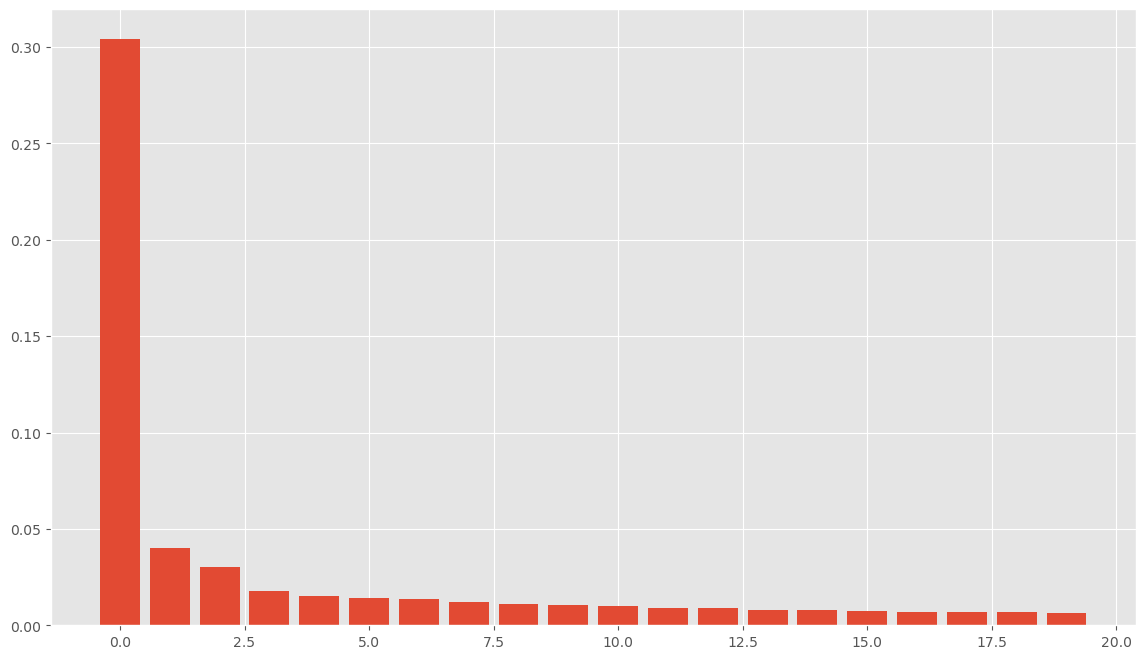

In [10]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

You will see that the first factor dominates. The precise definition of each factor in a latent model is unknown, however we can guess at the likely interpretation.

## Factor Betas
Implement `factor_betas` to get the factor betas from the PCA model.

In [11]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    #TODO: Implement function
    factor_betas = pd.DataFrame(pca.components_, index=factor_beta_columns, columns=factor_beta_indices)

    
    return factor_betas.T

project_test4.test_factor_betas(factor_betas)

Tests Passed


/home/ankit/AI_for_trading/Projects/../Notes/project_test4.py:26: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


### View Data
Let's view the factor betas from this model.

In [12]:
risk_model = {}
# assets = [asset.sid for asset in five_year_returns.columns]
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),0.06103401,-0.00850808,-0.02591471,0.02866233,0.01098552,-0.02343402,-0.01909532,-0.00651467,0.01384501,-0.02131200,-0.01368319,-0.02880076,0.02314484,-0.00763893,-0.01028110,-0.01571400,-0.00118606,-0.00287577,-0.02334790,-0.02911401
Equity(1 [AAL]),0.06346640,-0.08138904,-0.10733101,0.02975963,-0.01098784,0.23068900,0.35004878,-0.15828177,-0.17139794,-0.01402225,0.10367646,-0.15665595,-0.04437075,0.00664082,0.00628843,-0.04804614,-0.03292174,0.04046890,0.11771693,-0.07053791
Equity(2 [AAP]),0.04415077,-0.03635720,-0.00970985,-0.01356579,0.01853745,0.06768711,-0.04032719,0.02924790,-0.02140368,-0.00897144,0.02279493,-0.01642806,0.02196752,0.03077875,-0.00742415,0.02298332,-0.00737114,-0.02116088,-0.05245630,0.02053434
Equity(3 [AAPL]),0.04053183,-0.01280173,-0.01454172,0.02237253,0.04518757,-0.03125279,-0.02146909,-0.02915563,0.00273691,-0.06628920,-0.00825458,-0.01112051,-0.01928896,-0.00752044,-0.06108105,0.00964390,-0.02575654,0.03805403,-0.04817471,0.00664562
Equity(4 [ABBV]),0.03465498,-0.02448443,-0.00722560,0.08155269,-0.05993864,0.00116533,-0.02902897,0.00771818,-0.04497370,0.00178907,0.00761239,-0.02854264,0.07738804,0.02830606,-0.01619719,0.03828748,0.00629732,-0.02394305,-0.01711109,0.03339659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Equity(403 [XYL]),0.03639795,0.01868233,0.00100880,0.00327189,-0.00631379,-0.00342549,-0.00707272,-0.03138749,0.01182933,0.00934511,0.02743360,-0.06774146,0.00677059,-0.00716239,0.00617701,0.01110328,0.01431660,-0.03995785,0.01666937,0.01813571
Equity(404 [YUM]),0.04591791,-0.02867204,0.00344029,-0.01678605,0.00143853,0.01875243,-0.03020433,0.01486753,-0.02628499,-0.01010686,0.00403017,-0.01878901,0.00089882,-0.05948680,0.00726496,-0.01696833,0.01510633,0.02099691,-0.00362083,-0.02100855
Equity(405 [ZBH]),0.04254611,-0.02192120,0.00556979,0.04198147,-0.02492990,-0.02400518,-0.01180288,0.00036448,-0.01152815,0.01298232,-0.03648582,-0.02383107,0.06949351,-0.00575157,-0.03111103,-0.03753085,-0.01703032,-0.01656140,-0.00210752,0.01050483
Equity(406 [ZION]),0.06651613,0.05364256,-0.08443976,-0.07847640,-0.08380448,-0.04053237,0.02412049,0.03463108,-0.02265417,0.06167170,-0.00861141,-0.00146892,0.00919864,-0.04597997,0.02841985,-0.01637798,-0.00955014,0.06398830,-0.05158905,-0.02361022


## Factor Returns
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [13]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    #TODO: Implement function
    factor_returns = pca.transform(returns)
    factor_returns = pd.DataFrame(factor_returns, index=factor_return_indices, columns=factor_return_columns)
    
    return factor_returns


project_test4.test_factor_returns(factor_returns)

/home/ankit/AI_for_trading/Projects/../Notes/project_test4.py:26: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


Tests Passed


### View Data
Let's see what these factor returns looks like over time.

<Axes: >

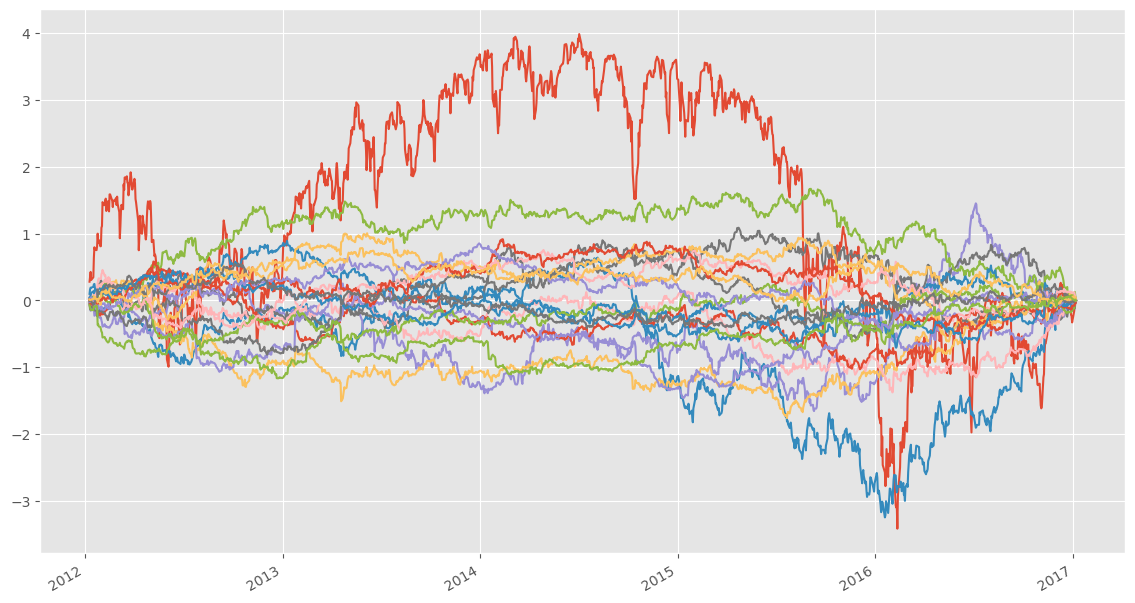

In [14]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None)

## Factor Covariance Matrix
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [15]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    
    #TODO: Implement function
    
    factor_cov_matrix = np.diag(factor_returns.var(axis=0, ddof=1)*ann_factor)

    return factor_cov_matrix


project_test4.test_factor_cov_matrix(factor_cov_matrix)

Tests Passed


### View Data

In [16]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[7.9969478 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.0542818 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.79142531, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.4696118 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

## Idiosyncratic Variance Matrix
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [17]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    s = returns - pd.DataFrame(np.dot(factor_returns,factor_betas.T),index=returns.index,columns=returns.columns)

    idiosyncratic_var_matrix = np.var(s)
    idiosyncratic_var_matrix = pd.DataFrame(np.diag(idiosyncratic_var_matrix)*ann_factor,index = returns.columns,columns = returns.columns)

    return idiosyncratic_var_matrix


project_test4.test_idiosyncratic_var_matrix(idiosyncratic_var_matrix)

Tests Passed


/home/ankit/AI_for_trading/Projects/../Notes/project_test4.py:26: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(
/home/ankit/miniconda3/envs/ML/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


### View Data

In [18]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

/home/ankit/miniconda3/envs/ML/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABT]),Equity(6 [ACN]),Equity(7 [ADBE]),Equity(8 [ADI]),Equity(9 [ADM]),...,Equity(398 [WYNN]),Equity(399 [XEL]),Equity(400 [XOM]),Equity(401 [XRAY]),Equity(402 [XRX]),Equity(403 [XYL]),Equity(404 [YUM]),Equity(405 [ZBH]),Equity(406 [ZION]),Equity(407 [ZTS])
Equity(0 [A]),0.02551879,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(1 [AAL]),0.00000000,0.03292859,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(2 [AAP]),0.00000000,0.00000000,0.05801224,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(3 [AAPL]),0.00000000,0.00000000,0.00000000,0.04986072,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
Equity(4 [ABBV]),0.00000000,0.00000000,0.00000000,0.00000000,0.03449307,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Equity(403 [XYL]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02371547,0.00000000,0.00000000,0.00000000,0.00000000
Equity(404 [YUM]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.04141311,0.00000000,0.00000000,0.00000000
Equity(405 [ZBH]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02377084,0.00000000,0.00000000
Equity(406 [ZION]),0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.02100785,0.00000000


## Idiosyncratic Variance Vector
Implement `idiosyncratic_var_vector` to get the idiosyncratic variance Vector.

In [19]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    # get diagonal values of idiosyncratic variance matrix
    idiosyncratic_var_vector = pd.DataFrame(np.diagonal(idiosyncratic_var_matrix),index = returns.columns)
    
    
    return idiosyncratic_var_vector


project_test4.test_idiosyncratic_var_vector(idiosyncratic_var_vector)

Tests Passed


/home/ankit/AI_for_trading/Projects/../Notes/project_test4.py:26: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


### View Data

In [20]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
Equity(0 [A]),0.02551879
Equity(1 [AAL]),0.03292859
Equity(2 [AAP]),0.05801224
Equity(3 [AAPL]),0.04986072
Equity(4 [ABBV]),0.03449307
...,...
Equity(403 [XYL]),0.02371547
Equity(404 [YUM]),0.04141311
Equity(405 [ZBH]),0.02377084
Equity(406 [ZION]),0.02100785


## Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [21]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    
    #TODO: Implement function
    predict_portfolio_risk = np.sqrt(weights.T.dot(factor_betas.dot(factor_cov_matrix).dot(factor_betas.T) + idiosyncratic_var_matrix).dot(weights))

    # convert to float
    predict_portfolio_risk = predict_portfolio_risk.to_numpy()[0][0]
    
    return predict_portfolio_risk


project_test4.test_predict_portfolio_risk(predict_portfolio_risk)

Tests Passed


/home/ankit/AI_for_trading/Projects/../Notes/project_test4.py:26: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


### View Data
Let's see what the portfolio risk would be if we had even weights across all stocks.

In [22]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.13401522347732284

# Create Alpha Factors
With the profile risk calculated, it's time to start working on the alpha factors. In this project, we'll create the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 1 Year Factor
Each factor will have a hypothesis that goes with it. For this factor, it is "Higher past 12-month (252 days) returns are proportional to future return." Using that hypothesis, we've generated this code:

In [23]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

## Mean Reversion 5 Day Sector Neutral Factor
Now it's time for you to implement `mean_reversion_5day_sector_neutral` using the hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." Use the returns data from `universe`, demean using the sector data to partition, rank, then converted to a zscore.

In [24]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    
    # logic is that we will return the negative as the if the return is more than the sector mean we want to short it

    factor = (
        Returns(window_length=window_length, mask=universe).
        demean(groupby=sector). #we use the custom Sector class that we reviewed earlier
        rank().
        zscore()
    )
    
    return -factor




### View Data
Let's see what some of the factor data looks like. For calculating factors, we'll be looking back 2 years.

**Note:** _Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open._

In [25]:
from Notes import project4_helper

factor_start_date = universe_end_date - pd.DateOffset(years=2)
sector = project4_helper.Sector()
window_length = 5

pipeline = Pipeline(screen=universe,domain=US_EQUITIES)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

/home/ankit/AI_for_trading/Projects/../Notes/project4_helper.py:34: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


Mean_Reversion_5Day_Sector_Neutral
2015-01-06 Equity(0 [A])                               1.55800136
           Equity(1 [AAL])                            -1.71082983
           Equity(2 [AAP])                             0.19952606
           Equity(3 [AAPL])                            1.69384889
           Equity(4 [ABBV])                            1.56649183
...                                                           ...
2017-01-06 Equity(403 [XYL])                           0.26744983
           Equity(404 [YUM])                           0.63254006
           Equity(405 [ZBH])                           0.27594030
           Equity(406 [ZION])                          0.61555912
           Equity(407 [ZTS])                           0.89574465

[206448 rows x 1 columns]

## Mean Reversion 5 Day Sector Neutral Smoothed Factor
Taking the output of the previous factor, let's create a smoothed version. Implement `mean_reversion_5day_sector_neutral_smoothed` to generate a mean reversion 5 fay sector neutral smoothed factor. Call the `mean_reversion_5day_sector_neutral` function to get the unsmoothed factor, then use `SimpleMovingAverage` function to smooth it. You'll have to apply rank and zscore again.

In [26]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    
    # get unsmoothed factor
    factor = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    
    # get smoothed factor
    factor_smoothed = SimpleMovingAverage(inputs=[factor], window_length=window_length).rank().zscore()
    
    return factor_smoothed




### View Data
Let's see what some of the smoothed data looks like.

In [27]:
pipeline = Pipeline(screen=universe,domain=US_EQUITIES)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2015-01-06 Equity(0 [A])                                        1.20140160
           Equity(1 [AAL])                                     -1.72781077
           Equity(2 [AAP])                                      1.11649689
           Equity(3 [AAPL])                                     0.05518806
           Equity(4 [ABBV])                                     0.19952606
...                                                                    ...
2017-01-06 Equity(403 [XYL])                                    1.37970148
           Equity(404 [YUM])                                    0.87027324
           Equity(405 [ZBH])                                   -0.91272559
           Equity(406 [ZION])                                   1.23536348
           Equity(407 [ZTS])                                    0.17405465

[206448 rows x 1 columns]

## Overnight Sentiment Factor
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

In [28]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Overnight Sentiment Smoothed Factor
Just like the factor you implemented, we'll also smooth this factor.

In [29]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Combine the Factors to a single Pipeline
With all the factor implementations done, let's add them to a pipeline.

In [30]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = project4_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

/home/ankit/AI_for_trading/Projects/../Notes/project4_helper.py:34: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


Momentum_1YR  Mean_Reversion_5Day_Sector_Neutral  \
2015-01-06 Equity(0 [A])      -1.61743466                          1.55800136   
           Equity(1 [AAL])     1.70233936                         -1.71082983   
           Equity(2 [AAP])     1.48158713                          0.19952606   
           Equity(3 [AAPL])    1.22687301                          1.69384889   
           Equity(4 [ABBV])    0.24197841                          1.56649183   

                             Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2015-01-06 Equity(0 [A])                                      1.20140160   
           Equity(1 [AAL])                                   -1.72781077   
           Equity(2 [AAP])                                    1.11649689   
           Equity(3 [AAPL])                                   0.05518806   
           Equity(4 [ABBV])                                   0.19952606   

                             Overnight_Sentiment  Overnight_Sentiment_Smoothed  
2015-01-06 Equity(0 [A])              0.06367853                    0.68348289  
           Equity(1 [AAL])            1.70233936                    1.67686795  
           Equity(2 [AAP])            1.55800136                    1.55800136  
           Equity(3 [AAPL])           0.27594030                   -0.14009277  
           Equity(4 [ABBV])          -1.15045877                    0.03820712

# Evaluate Alpha Factors
*Note:* _We're evaluating the alpha factors using delay of 1_
## Get Pricing Data

In [31]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

## Format alpha factors and pricing for Alphalens
In order to use a lot of the alphalens functions, we need to aligned the indices and convert the time to unix timestamp. In this next cell, we'll do just that.

In [32]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.items()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Quantile Analysis
### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

<Axes: xlabel='date'>

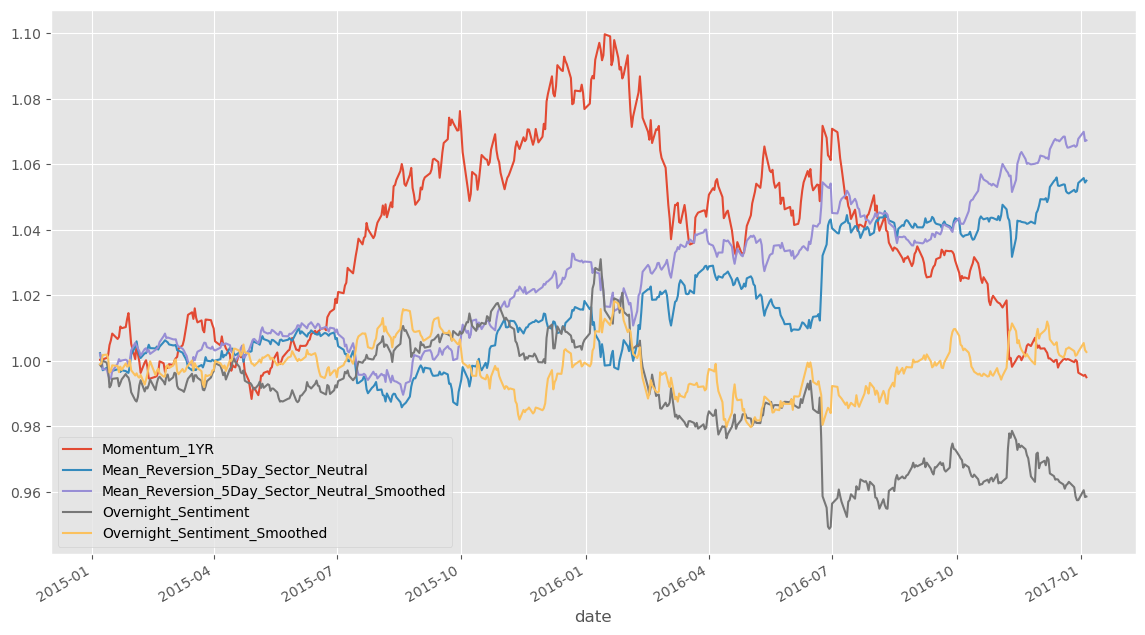

In [33]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

array([[<Axes: title={'center': 'Momentum_1YR'}, xlabel='factor_quantile'>,
        <Axes: title={'center': 'Mean_Reversion_5Day_Sector_Neutral'}, xlabel='factor_quantile'>],
       [<Axes: title={'center': 'Mean_Reversion_5Day_Sector_Neutral_Smoothed'}, xlabel='factor_quantile'>,
        <Axes: title={'center': 'Overnight_Sentiment'}, xlabel='factor_quantile'>],
       [<Axes: title={'center': 'Overnight_Sentiment_Smoothed'}, xlabel='factor_quantile'>,
        <Axes: xlabel='factor_quantile'>],
       [<Axes: xlabel='factor_quantile'>,
        <Axes: xlabel='factor_quantile'>]], dtype=object)

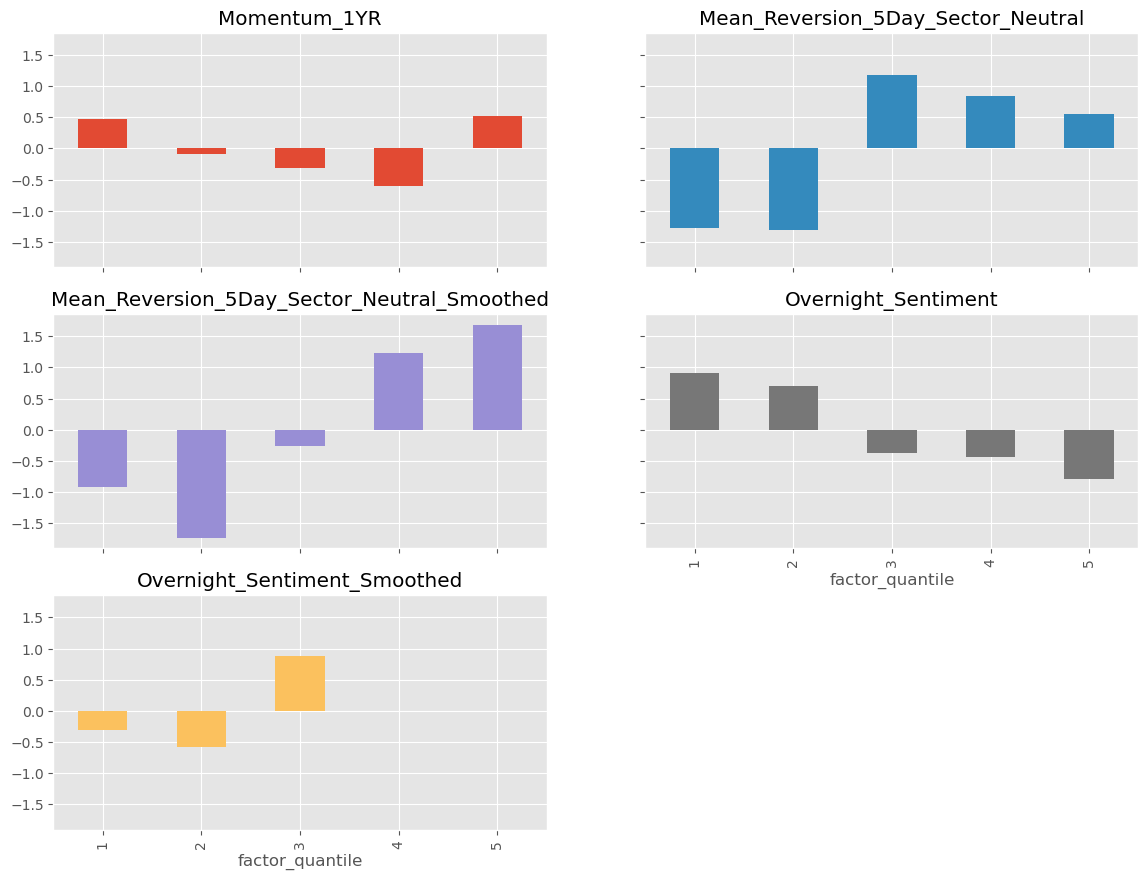

In [34]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

What do you observe?

- None of these alphas are **strictly monotonic**; this should lead you to question why this is? Further research and refinement of the alphas needs to be done. What is it about these alphas that leads to the highest ranking stocks in all alphas except MR 5D smoothed to *not* perform the best.
- The majority of the return is coming from the **short side** in all these alphas. The negative return in quintile 1 is very large in all alphas. This could also a cause for concern becuase when you short stocks, you need to locate the short; shorts can be expensive or not available at all.
- If you look at the magnitude of the return spread (i.e., Q1 minus Q5), we are working with daily returns in the 0.03%, i.e., **3 basis points**, neighborhood *before all transaction costs, shorting costs, etc.*. Assuming 252 days in a year, that's 7.56% return annualized. Transaction costs may cut this in half. As such, it should be clear that these alphas can only survive in an institutional setting and that leverage will likely need to be applied in order to achieve an attractive return.

## Turnover Analysis

Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **factor rank autocorrelation (FRA)**.

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

<Axes: title={'center': 'Factor Rank Autocorrelation'}, xlabel='date'>

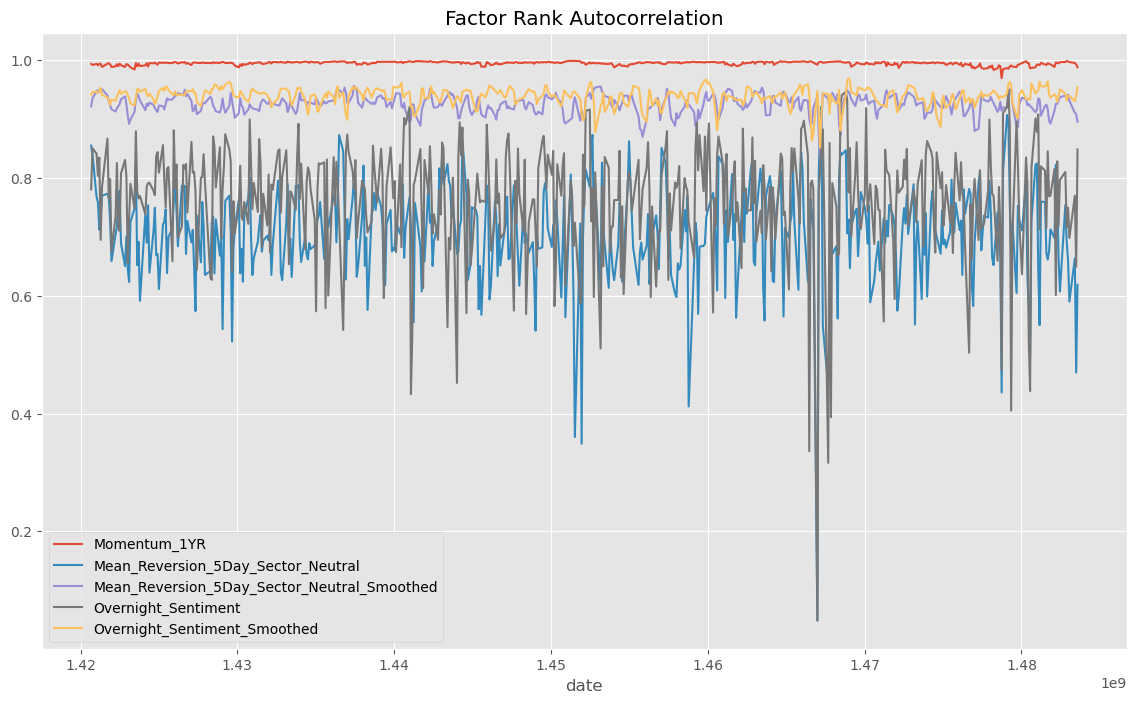

In [35]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

## Sharpe Ratio of the Alphas

The last analysis we'll do on the factors will be sharpe ratio. Implement `sharpe_ratio` to calculate the sharpe ratio of factor returns.

In [36]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    
    #TODO: Implement function
    sharpe_ratio = factor_returns.mean()/factor_returns.std()*annualization_factor
    
    return sharpe_ratio


project_test4.test_sharpe_ratio(sharpe_ratio)

Tests Passed


### View Data
Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [37]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Momentum_1YR                                  -0.03000000
Mean_Reversion_5Day_Sector_Neutral             0.92000000
Mean_Reversion_5Day_Sector_Neutral_Smoothed    1.22000000
Overnight_Sentiment                           -0.53000000
Overnight_Sentiment_Smoothed                   0.06000000
dtype: float64

Smoothing the factors make the sharpe ratio more robust. 

## The Combined Alpha Vector

To use these alphas in a portfolio, we need to combine them somehow so we get a single score per stock. This is a area where machine learning can be very helpful. In this module, however, we will take the simplest approach of combination: simply averaging the scores from each alpha.

In [38]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector.head()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral, Mean_Reversion_5Day_Sector_Neutral_Smoothed, Overnight_Sentiment_Smoothed


,alpha_vector
asset,
Equity(0 [A]),0.31556249
Equity(1 [AAL]),1.34573960
Equity(2 [AAP]),-0.23065779
Equity(3 [AAPL]),-0.73442571
Equity(4 [ABBV]),-0.17405465


# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [39]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve()

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [40]:
import cvxpy as cvx
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        obj = cvx.Maximize(alpha_vector.values.flatten().T@weights)
        
        return obj
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function
       
        constraints = [
            risk <= self.risk_cap*self.risk_cap, 
            factor_betas.T@weights <= self.factor_max, 
            factor_betas.T@weights >= self.factor_min, 
            sum(weights) == 0.0, 
            sum(cvx.abs(weights)) <= 1.0, 
            weights >= self.weights_min,
            weights <= self.weights_max
        ]
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

# project_test4.test_optimal_holdings_get_obj(OptimalHoldings)
# project_test4.test_optimal_holdings_get_constraints(OptimalHoldings)

### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

/home/ankit/miniconda3/envs/ML/lib/python3.9/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/home/ankit/miniconda3/envs/ML/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


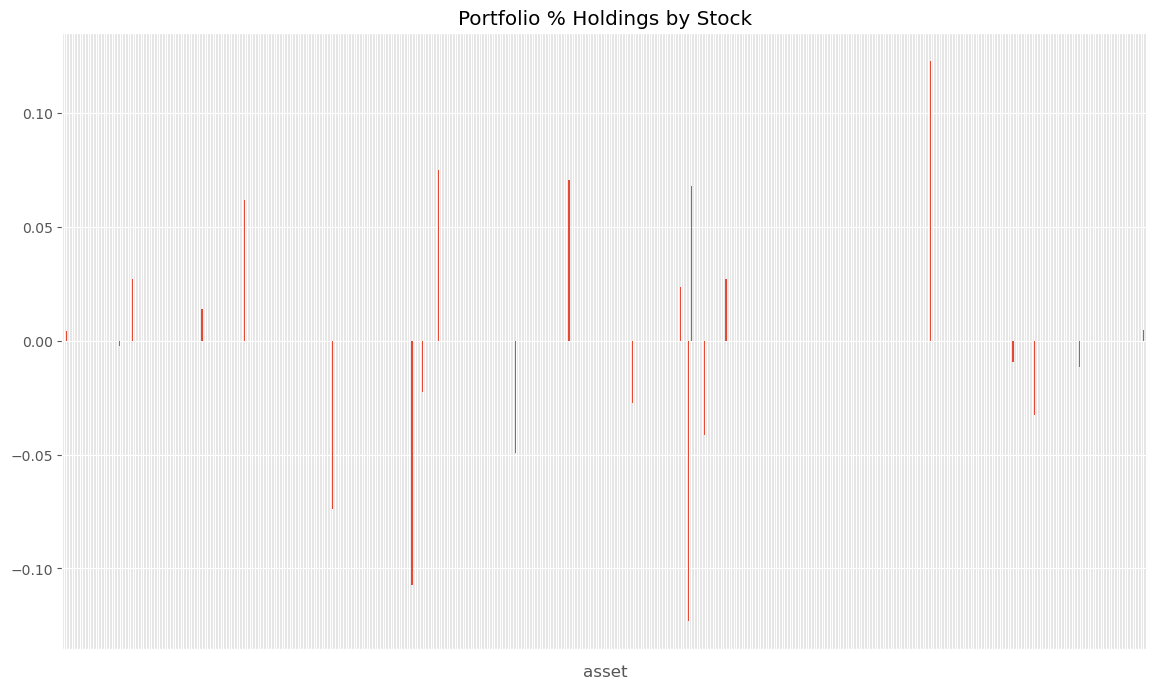

In [41]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])


# Plot the bar chart
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')

# Remove x-tick labels directly from the plot
plt.gca().set_xticklabels([])  # Clear x-axis tick labels
plt.gca().xaxis.set_ticks_position('none')  # Remove tick marks

# Display the plot
plt.show()

Yikes. It put most of the weight in a few stocks.

<Axes: title={'center': 'Portfolio Net Factor Exposures'}>

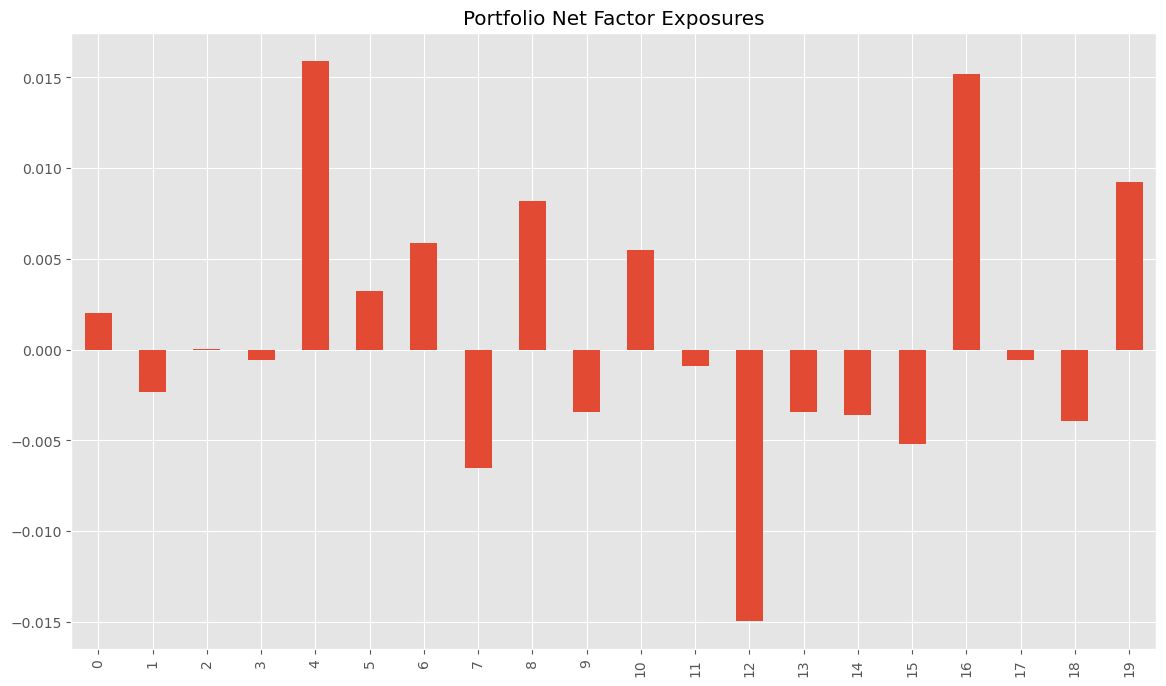

In [42]:
project4_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [43]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        
        
        objective = cvx.Maximize(alpha_vector.values.flatten().T@weights - self.lambda_reg*cvx.norm(weights,2)) #maximizes 𝛼𝑇∗𝑥+𝜆‖𝑥‖2
        
        return objective

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min
        

# project_test4.test_optimal_holdings_regualization_get_obj(OptimalHoldingsRegualization)

### View Data

/home/ankit/miniconda3/envs/ML/lib/python3.9/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


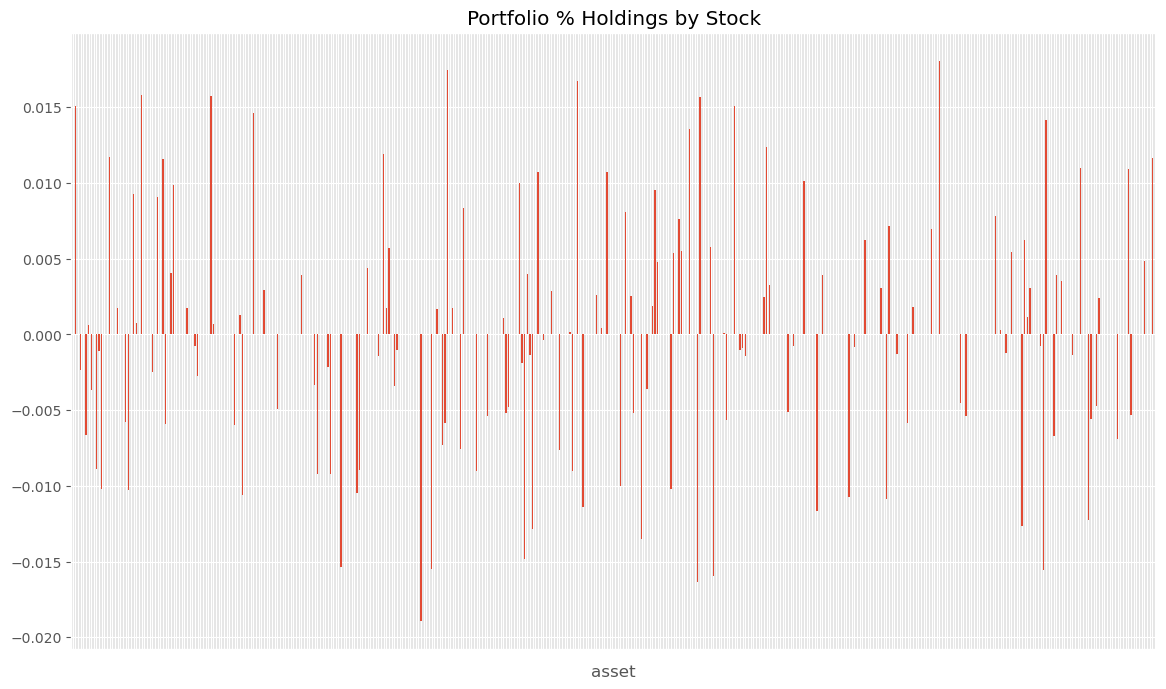

In [44]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

# Plot the bar chart
optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')

# Remove x-tick labels directly from the plot
plt.gca().set_xticklabels([])  # Clear x-axis tick labels
plt.gca().xaxis.set_ticks_position('none')  # Remove tick marks

# Display the plot
plt.show()

Nice. Well diversified.

<Axes: title={'center': 'Portfolio Net Factor Exposures'}>

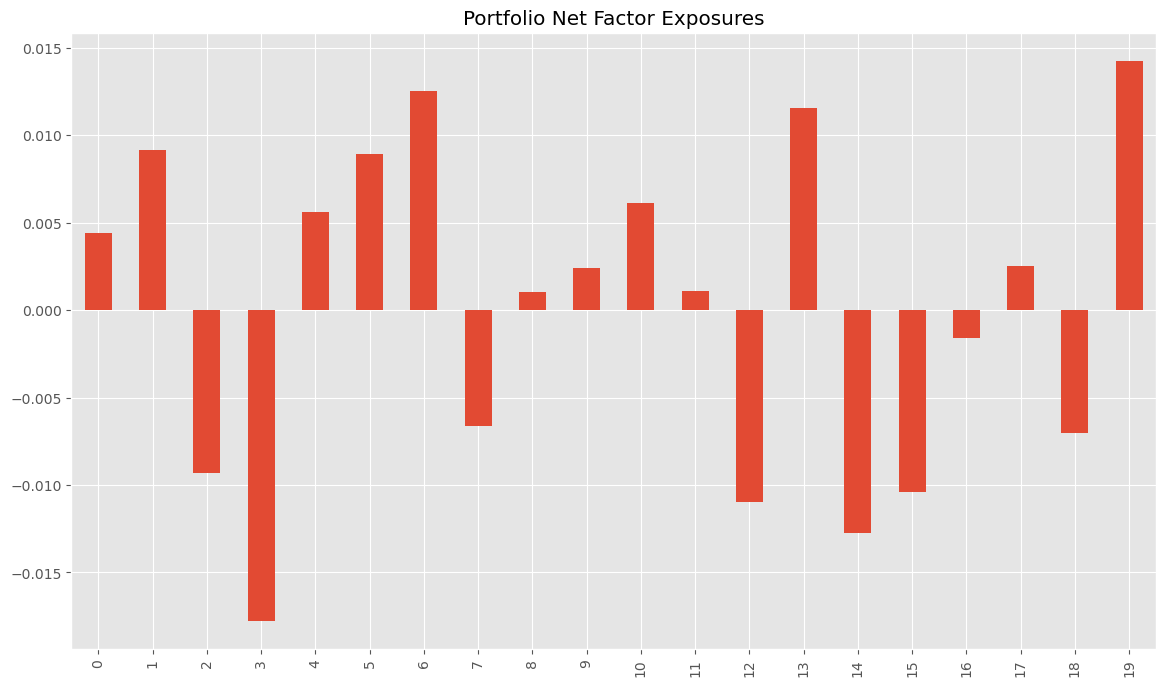

In [45]:
project4_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [46]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        # target weights
        alpha_norm = (alpha_vector - alpha_vector.mean())/sum(abs(alpha_vector.values))
        objective = cvx.Minimize(cvx.norm(weights - alpha_norm["alpha_vector"],2))
        
        return objective


project_test4.test_optimal_holdings_strict_factor_get_obj(OptimalHoldingsStrictFactor)

Running Integration Test on Problem.solve:
> constaints = [sum(weights) == 0.0, sum(cvx.abs(weights)) <= 1.0]
> obj = optimal_holdings_strict_factor._get_obj(weights, alpha_vector)
> prob = cvx.Problem(obj, constaints)
> prob.solve(max_iters=500)
> solution = np.asarray(weights.value).flatten()

Tests Passed


/home/ankit/AI_for_trading/Projects/../Notes/project_test4.py:26: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


### View Data

/home/ankit/miniconda3/envs/ML/lib/python3.9/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


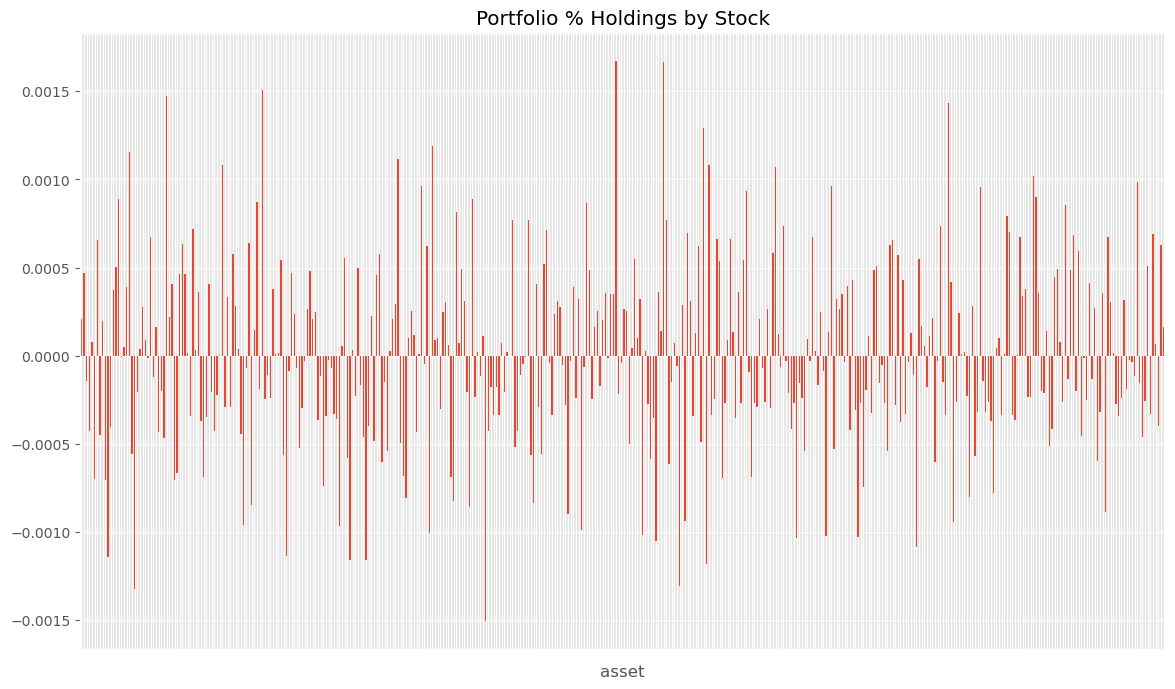

In [49]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])



# Plot the bar chart
optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')

# Remove x-tick labels directly from the plot
plt.gca().set_xticklabels([])  # Clear x-axis tick labels
plt.gca().xaxis.set_ticks_position('none')  # Remove tick marks

# Display the plot
plt.show()

<Axes: title={'center': 'Portfolio Net Factor Exposures'}>

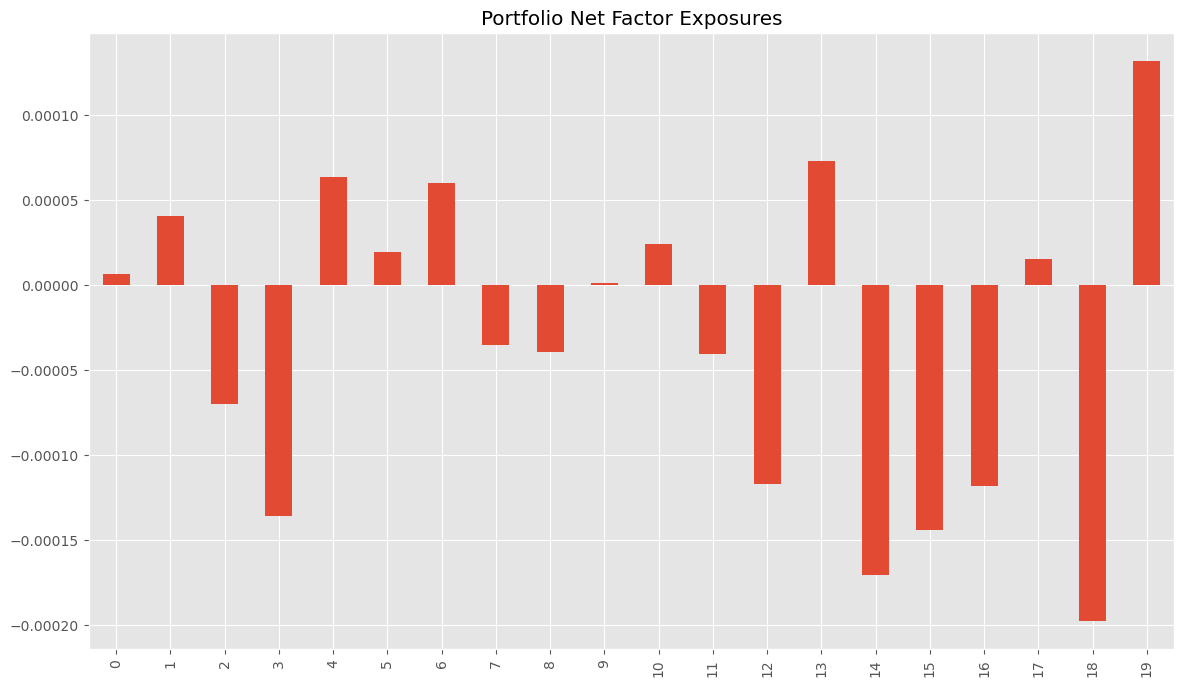

In [50]:
project4_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

This project demonstrate a quant workflow which includes alpha research and risk management. 